In [ ]:
! pip install import-ipynb
! pip install ipynb
! pip install arch
! pip install numpy 
! pip install matplotlib
! pip install scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from arch.univariate import GARCH, ZeroMean
import pandas as pd 
from math import log 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [84]:
np.random.seed(12345)
n = 1000        
n1 = 100        
n2 = n + n1    
omega = 0.1
alpha = 0.2   
beta = 0.7
errors = np.random.normal(0,1,n2) 
h2 = np.zeros(n2)
r = np.zeros(n2)
h2[0] = omega
for i in range(1,n2-1): 
    h2[i] = omega + alpha*h2[i-1]*errors[i-1]**2 + beta*h2[i-1]
    r[i] = np.sqrt(h2[i])*errors[i]
h = h2[n1-1:-1]
y = r[n1-1:-1]    
Prix = pd.read_csv("EUR_USD Historical Data.csv")['Price']
r = []
for i in range(len(Prix)-1) :
    r.append(log(Prix[i+1]/ Prix[i])*100)
def prior(omega, var):
    P = 1
    for i in range (len(omega)):
            P = P* np.exp(-0.5 * (omega[i]**2/var[i]))
    return P
def likelihood(returns, omega):
    T = 100
    h = np.zeros(T)
    h[0] = 1.4128118384007489 # à la première valeur de h on associe la variance des taux d'intérêt.
    
    for t in range(1, T):
        h[t] = omega[0] + omega[2] * h[t-1] + omega[1] * (returns[t-1] ** 2)
    L = np.prod((10/np.sqrt(h)) * np.exp(-0.5*(np.array(returns[:100])**2)/h))
    return L
def posterior (returns, omega, var) :
    return prior (omega,var) * likelihood(returns,omega)
def metropolis2 (returns, omega_current, n_iter, var, sigma):
    j = 0 
    omega_matrix = omega_current 
    np.random.seed(12)
    for i in range (0,n_iter):
        omega_n = omega_current + np.random.normal(loc=0, scale=sigma, size=3)
        while np.any(omega_n <=0 ) :
            omega_n = omega_current + np.random.normal(loc=0, scale=sigma, size=3)
        r = posterior (returns, omega_n, var)/posterior (returns, omega_current, var)
        if np.random.uniform() < min(1,r) : 
            omega_current = omega_n 
            j = j + 1
        omega_matrix = np.vstack((omega_matrix, omega_current)) 
    return j/n_iter, omega_matrix
omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
Sigma_opt_sim = 0.1
echant_sim_2 = metropolis2 (y, omega_current, 3000, var, Sigma_opt_sim)[1]
echant_sim_10 = metropolis2 (y, omega_current, 11000, var, Sigma_opt_sim)[1]
Sigma_opt_reel = 0.019195959595959596
echant_reel_2 = metropolis2 (r, omega_current, 3000, var, Sigma_opt_reel)[1]
echant_reel_10 = metropolis2 (r, omega_current, 11000, var, Sigma_opt_reel)[1]
def calcul_z_1(omega, h, r, var_emp):
    T = len(h)
    z_1 = omega[:,0] / (2 * var_emp[0] ** 2)
    z_2 = omega[:,1] / (2 * var_emp[1] ** 2)
    z_3 = omega[:,2] / (2 * var_emp[2] ** 2)
    for t in range(1,T):
        dht_domega1 = (1 - omega[:,2] ** (t-1)) / (1 - omega[:,2])
        z_1 += 0.25 * (1/h[t]) * dht_domega1 - int((r[t] ** 2 / h[t]**2)) * dht_domega1
        dht_domega2 = np.array([np.sum([w_i**(t-2-i) * r[i]**2 for i in range(t-1)]) for w_i in omega[:,1]])
        z_2 += 0.25 * (1/h[t]) * dht_domega2 - r[t] ** 2 / h[t]**2 * dht_domega2
        dht_domega3 = np.array([np.sum([w_i**(t-2-i) * h[i]**2 for i in range(t-1)]) for w_i in omega[:,2]])
        z_3 += 0.25 * (1/h[t]) * dht_domega3 - (r[t] ** 2 / h[t]) * dht_domega3
    return np.column_stack([z_1, z_2, z_3])
CV1_sim_1_c = calcul_z_1(echant_sim_2, h[:100], y[:100], np.var(echant_sim_2, axis = 0))
CV1_sim_1_l = calcul_z_1(echant_sim_10, h[:100], y[:100], np.var(echant_sim_10, axis = 0))
def z1(x,r,var):
    Z = 0
    h = 0 
    for i in range(1, len(r)):
        h = x[0] + x[1] * r[i-1]**2 + x[2] * h
        Z += (1-x[2]**(i))/(1-x[2]) * (-(0.5/h) + (0.5 * r[i]**2)/(h**2))
    return -1/2 * (- x[0]/var[0] + Z)
def z2(x , r,var):
    Z = 0
    h_t = 0
    dht_domega2 = 0 #initial derivatves of h wrt alpha (x[1])
    
    for i in range(1, len(r)):
        h = h_t
        dht_domega2 = r[i-1]**2 + x[2]*dht_domega2
        h_t = x[0] + x[1] * r[i-1]**2 + x[2] * h
        Z += (dht_domega2) * (-(0.5/h_t) + (0.5 * r[i]**2)/(h_t**2))
    return -1/2 * (- x[1]/var[1] + Z)
def z3(x , r, var):
    Z = 0
    h_t = 0
    dht_domega3 = 0 #initial derivatves of h wrt beta (x[2])
    for i in range(1, len(r)):
        h = h_t
        dht_domega3 = h + x[2]*dht_domega3
        h_t = x[0] + x[1] * r[i-1]**2 + x[2] * h
        Z += (dht_domega3) * (-(0.5/h_t) + (0.5 * r[i]**2)/(h_t**2))
    return -1/2 * (- x[2]/var[2] + Z)
def calcul_z_2(echant, r, var):
    Z1 = []
    Z2 = []
    Z3 = []
    for x in echant:
        Z1.append(z1(x, r, var))
        Z2.append(z2(x, r, var))
        Z3.append(z3(x, r, var))
    return np.column_stack([Z1, Z2, Z3])
CV1_sim_2_c = calcul_z_2(echant_sim_2, y[:100], np.var(echant_sim_2, axis = 0))
CV1_sim_2_l = calcul_z_2(echant_sim_10, y[:100], np.var(echant_sim_10, axis = 0))
def combi_omega(k, echant, CV_court, CV_long):
    model = sm.OLS(echant[:,k], CV_court) 
    results = model.fit(cov_type='HC3') 
    coeff_opt = results.params 
    combi = np.dot(coeff_opt, CV_long.transpose())
    print(results.summary())
    return combi
def enlever_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    limite_inferieure = Q1 - 10 * IQR
    limite_superieure = Q3 + 10 * IQR
    donnees_sans_outliers = np.copy(data)
    for i in range(1, len(data)):
        if (data[i] < limite_inferieure).any() or (data[i] > limite_superieure).any():
            donnees_sans_outliers[i] = donnees_sans_outliers[i - 1]
    return donnees_sans_outliers
combi_omega1 = combi_omega(0, echant_sim_2, CV1_sim_1_c, CV1_sim_1_l)
omega_tilde_1 = echant_sim_10[:,0] - combi_omega1
omega_tilde_1ss_z1 = enlever_outliers(omega_tilde_1)
combi_omega2 = combi_omega(1, echant_sim_2, CV1_sim_1_c, CV1_sim_1_l)
omega_tilde_2 = echant_sim_10[:,1] - combi_omega2
omega_tilde_2ss_z1 = enlever_outliers(omega_tilde_2)
combi_omega3 = combi_omega(2, echant_sim_2, CV1_sim_1_c, CV1_sim_1_l)
omega_tilde_3 = echant_sim_10[:,2] - combi_omega3
omega_tilde_3ss_z1 = enlever_outliers(omega_tilde_3)
# combi_omega1 = combi_omega(0, echant_sim_2, CV1_sim_2_c, CV1_sim_2_l)
# omega_tilde_1 = echant_sim_10[:,0] - combi_omega1
# omega_tilde_1ss_z2 = enlever_outliers(omega_tilde_1)
# combi_omega2 = combi_omega(1, echant_sim_2, CV1_sim_2_c, CV1_sim_2_l)
# omega_tilde_2 = echant_sim_10[:,1] - combi_omega2
# omega_tilde_2ss_z2 = enlever_outliers(omega_tilde_2)
# combi_omega3 = combi_omega(2, echant_sim_2, CV1_sim_2_c, CV1_sim_2_l)
# omega_tilde_3 = echant_sim_10[:,2] - combi_omega3
# omega_tilde_3ss_z2 = enlever_outliers(omega_tilde_3)
omega1 = echant_reel_2[:,0].mean()
omega2 = echant_reel_2[:,1].mean()
omega3 = echant_reel_2[:,2].mean()
h_reel = np.zeros(len(r[:100])) 
for t in range(1,len(r[:100])) :
    h_reel[t] = omega1 + omega2 * h_reel[t-1] + omega3 * r[t-1]**2
CV1_reel_1_c = calcul_z_1(echant_reel_2, h_reel, r[:100], np.var(echant_reel_2, axis = 0))
CV1_reel_1_l = calcul_z_1(echant_reel_10, h_reel, r[:100], np.var(echant_reel_10, axis = 0))
combi_omega1_reel = combi_omega(0, echant_reel_2, CV1_reel_1_c, CV1_reel_1_l)
omega_tilde_1_reel = echant_reel_10[:,1] - combi_omega1_reel
omega_tilde_1ss_reel = enlever_outliers(omega_tilde_1_reel)
combi_omega2_reel = combi_omega(1, echant_reel_2, CV1_reel_1_c, CV1_reel_1_l)
omega_tilde_2_reel = echant_reel_10[:,1] - combi_omega2_reel
omega_tilde_2ss_reel = enlever_outliers(omega_tilde_2_reel)
combi_omega3_reel = combi_omega(2, echant_reel_2, CV1_reel_1_c, CV1_reel_1_l)
omega_tilde_3_reel = echant_reel_10[:,1] - combi_omega3_reel
omega_tilde_3ss_reel = enlever_outliers(omega_tilde_3_reel)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.745e+07
Date:                Tue, 30 Apr 2024   Prob (F-statistic):                        0.00
Time:                        02:18:44   Log-Likelihood:                          14528.
No. Observations:                3001   AIC:                                 -2.905e+04
Df Residuals:                    2998   BIC:                                 -2.903e+04
Df Model:                           3                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

## A. Approche naîve : Une seule régression

Avec des polynômes d'ordre 2, nous disposons de 9 variables de contrôle. Ces variables sont définies à partir des variables de contrôle d'ordre 1 et des paramètres omega.

L'approche naîve ZV-MCMC d'ordre 2 consiste en trois étapes :

1. Une courte simulation MCMC (de taille 2000) pour générer un échantillon omega, à partir duquel on génère un échantillon de variables de contrôle d'ordre 1 : CV1 ou Z (notation de l'article). Ces deux derniers sont ensuite utilisés pour générer un échantillon CV2 de 9 variables de contrôle d'ordre 2.

2. Une régression linéaire de omega sur les 9 variables CV2 est faite pour estimer les coefficients optimaux des variables CV2.

3. Une longue simulation MCMC (de taille 10000) pour générer un nouvel échantillon omega, CV1 ensuite CV2. On définit chaque $\tilde{\omega_i}$ comme la somme de $\omega_i$ et la somme des CV2 pondérée par les coefficients optimaux trouvés à l'étape 2.

$$\tilde{\omega_i} = \omega_i - \sum_{i=1}^{9} \hat{a}_i \times \text{CV2}_i$$ 

   où les $\hat{a}_i$ sont les coefficients de la régression linéaire de l'étape 2.

**Echantilllonnage des $\tilde{\omega_i}$** <br>
Pour les données simulées :

In [12]:
def control_variates_2 (x,z):
    """
    Args:
        x (np.array): échantillon de paramètres (omega1, omega2, omega3)
        z (np.array): échantillon de variables de contrôle d'ordre 1 (z1,z2,z3)

    Returns:
        np.array: un échantillon de 9 variables de contrôle, ZV-MCMC d'ordre 2
    """
    i = np.ones(z.shape)
    u = z*x -0.5*i
    v1 = x[:,1]*z[:,0] + x[:,0]*z[:,1]
    v2 = x[:,2]*z[:,0] + x[:,0]*z[:,2]
    v3 = x[:,2]*z[:,1] + x[:,1]*z[:,2]
    v = np.column_stack((v1, v2, v3))
    vT = v.transpose()
    uT = u.transpose()
    zT = z.transpose()
    zTuTvT = np.concatenate((zT, uT, vT), axis = 0)

    # CV2 est un échantillon de même taille que x et z de 9-uplets ; Pour ZV-MCMC de degré 2 on a 9 variables de contrôles
    # Une colonne de CV2 est une variable de contôle 
    CV2 = zTuTvT.transpose()

    return CV2

In [85]:
# 1. Courte et longue simulation des variables de contrôle d'ordre 2

CV2_sim_c = control_variates_2 (echant_sim_2, CV1_sim_1_c)
CV2_sim_l = control_variates_2 (echant_sim_10, CV1_sim_1_l)

In [86]:
# 3. Définition des omega_tilde après de longs échantillonnage MCMC

# ------------------------------------- Omega_1_tilde --------------------------------------------------------------

combi_omega1_d2 = combi_omega(0, echant_sim_2, CV2_sim_c, CV2_sim_l)
omega_tilde_1_d2 = echant_sim_10[:,0] - combi_omega1_d2
omega_tilde_1ss_d2 = enlever_outliers(combi_omega1_d2)

# ------------------------------------- Omega_1_tilde --------------------------------------------------------------

combi_omega2_d2 = combi_omega(1, echant_sim_2, CV2_sim_c, CV2_sim_l)
omega_tilde_2_d2 = echant_sim_10[:,1] - combi_omega2_d2
omega_tilde_2ss_d2 = enlever_outliers(omega_tilde_2_d2)

# ------------------------------------- Omega_1_tilde --------------------------------------------------------------

combi_omega3_d2 = combi_omega(2, echant_sim_2, CV2_sim_c, CV2_sim_l)
omega_tilde_3_d2 = echant_sim_10[:,2] - combi_omega3_d2
omega_tilde_3ss_d2 = enlever_outliers(omega_tilde_3_d2)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          7.701e+07
Date:                Tue, 30 Apr 2024   Prob (F-statistic):                        0.00
Time:                        02:19:32   Log-Likelihood:                          17332.
No. Observations:                3001   AIC:                                 -3.465e+04
Df Residuals:                    2992   BIC:                                 -3.459e+04
Df Model:                           9                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

**Visualisation des trajectoires des $\tilde{\omega_i}$** <br>
Pour les données simulées :

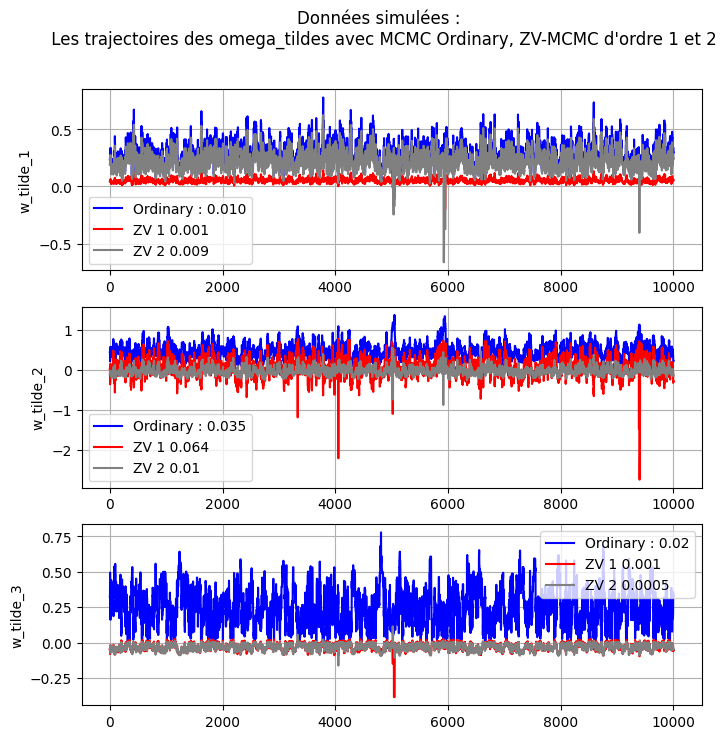

In [87]:

fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(10001), echant_sim_10[:,0][1000:], label="Ordinary : {:.3f}".format(np.var(echant_sim_10[1000:,0])), color = 'blue')
axs[0].plot(range(10001), omega_tilde_1ss_z1[1000:], label="ZV 1 {:.3f}".format(np.var(omega_tilde_1ss_z1[1000:])), color = 'red')
axs[0].plot(range(10001), omega_tilde_1ss_d2[1000:], label="ZV 2 {:.3f}".format(np.var(omega_tilde_1ss_d2[1000:])), color = 'grey')
axs[0].set_ylabel('w_tilde_1')
axs[0].legend()
axs[0].grid()

axs[1].plot(range(10001), echant_sim_10[:,1][1000:], label="Ordinary : {:.3f}".format(np.var(echant_sim_10[1000:,1])), color = 'blue')
axs[1].plot(range(10001), omega_tilde_2ss_z1[1000:],  label="ZV 1 {:.3f}".format(np.var(omega_tilde_2ss_z1[1000:])),  color = 'red')
axs[1].plot(range(10001), omega_tilde_2ss_d2[1000:], label="ZV 2 {:.2f}".format(np.var(omega_tilde_2ss_d2[1000:])), color = 'grey')
axs[1].set_ylabel('w_tilde_2')
axs[1].legend()
axs[1].grid()

axs[2].plot(range(10001), echant_sim_10[:,2][1000:], label="Ordinary : {:.2f}".format(np.var(echant_sim_10[1000:,2])), color = 'blue')
axs[2].plot(range(10001), omega_tilde_3ss_z1[1000:],  label="ZV 1 {:.3f}".format(np.var(omega_tilde_3ss_z1[1000:])), color = 'red')
axs[2].plot(range(10001), omega_tilde_3ss_d2[1000:], label="ZV 2 {:.4f}".format(np.var(omega_tilde_3ss_d2[1000:])), color = 'grey')
axs[2].set_ylabel('w_tilde_3')
axs[2].legend()
axs[2].grid()

plt.suptitle("Données simulées : \n Les trajectoires des omega_tildes avec MCMC Ordinary, ZV-MCMC d'ordre 1 et 2")
plt.show()

**Echantilllonnage des $\tilde{\omega_i}$** <br>
Pour les données réelles :

In [49]:
CV2_reel_c = control_variates_2 (echant_reel_2, CV1_reel_1_c)
CV2_reel_l = control_variates_2 (echant_reel_10, CV1_reel_1_l)

# ------------------------------------- Omega_1----------------------------------------------------------------

combi_omega1_d2_reel = combi_omega(0, echant_reel_2, CV2_reel_c, CV2_reel_l)
omega_tilde_1_d2_reel = echant_reel_10[:,0] - combi_omega1_d2_reel
omega_tilde_1ss_d2_reel = enlever_outliers(omega_tilde_1_d2_reel)

# ------------------------------------- Omega_2----------------------------------------------------------------

combi_omega2_d2_reel = combi_omega(1, echant_reel_2, CV2_reel_c, CV2_reel_l)
omega_tilde_2_d2_reel = echant_reel_10[:,1] - combi_omega2_d2_reel
omega_tilde_2ss_d2_reel = enlever_outliers(omega_tilde_2_d2_reel)

# ------------------------------------- Omega_3----------------------------------------------------------------

combi_omega3_d2_reel = combi_omega(2, echant_reel_2, CV2_reel_c, CV2_reel_l)
omega_tilde_3_d2_reel = echant_reel_10[:,2] - combi_omega3_d2_reel
omega_tilde_3ss_d2_reel = enlever_outliers(omega_tilde_3_d2_reel)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.157e+09
Date:                Tue, 30 Apr 2024   Prob (F-statistic):                        0.00
Time:                        00:42:37   Log-Likelihood:                          25216.
No. Observations:                3001   AIC:                                 -5.041e+04
Df Residuals:                    2992   BIC:                                 -5.036e+04
Df Model:                           9                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

**Visualisation des trajectoires des $\tilde{\omega_i}$** <br>
Pour les données réelles :

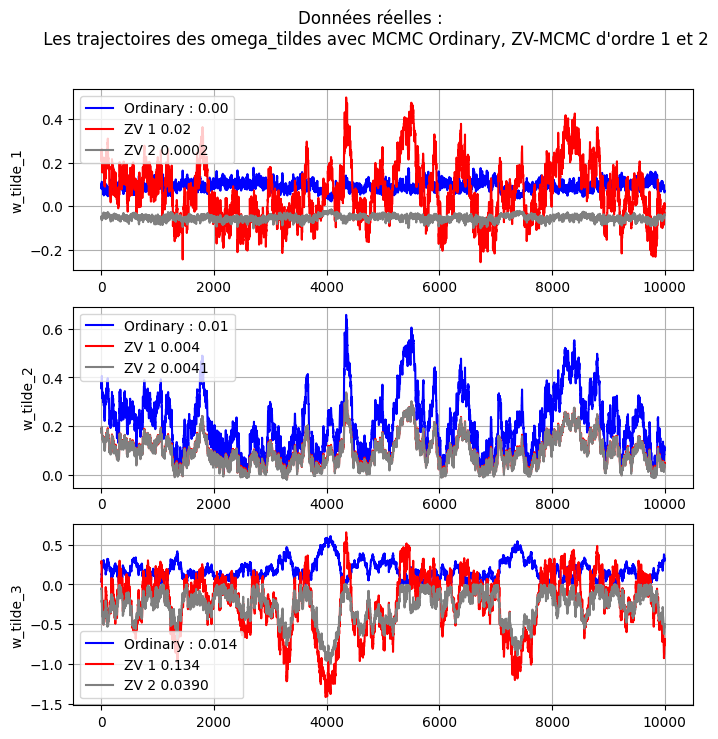

In [52]:

fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(10001), echant_reel_10[1000:,0], label="Ordinary : {:.2f}".format(np.var(echant_reel_10[1000:,0])), color = 'blue')
axs[0].plot(range(10001), omega_tilde_1ss_reel[1000:], label="ZV 1 {:.2f}".format(np.var(omega_tilde_1ss_reel[1000:])), color = 'red')
axs[0].plot(range(10001), omega_tilde_1ss_d2_reel[1000:], label="ZV 2 {:.4f}".format(np.var(omega_tilde_1ss_d2_reel[1000:])), color = 'grey')
axs[0].set_ylabel('w_tilde_1')
axs[0].legend()
axs[0].grid()

axs[1].plot(range(10001), echant_reel_10[1000:,1], label="Ordinary : {:.2f}".format(np.var(echant_reel_10[1000:,1])), color = 'blue')
axs[1].plot(range(10001), omega_tilde_2ss_reel[1000:], label="ZV 1 {:.3f}".format(np.var(omega_tilde_2ss_reel[1000:])),  color = 'red')
axs[1].plot(range(10001), omega_tilde_2ss_d2_reel[1000:], label="ZV 2 {:.4f}".format(np.var(omega_tilde_2ss_d2_reel[1000:])), color = 'grey')
axs[1].set_ylabel('w_tilde_2')
axs[1].legend()
axs[1].grid()

axs[2].plot(range(10001), echant_reel_10[:,2][1000:], label="Ordinary : {:.3f}".format(np.var(echant_reel_10[1000:,2])), color = 'blue')
axs[2].plot(range(10001), omega_tilde_3ss_reel[1000:], label="ZV 1 {:.3f}".format(np.var(omega_tilde_3ss_reel[1000:])), color = 'red')
axs[2].plot(range(10001), omega_tilde_3ss_d2_reel[1000:], label="ZV 2 {:.4f}".format(np.var(omega_tilde_3ss_d2_reel[1000:])), color = 'grey')
axs[2].set_ylabel('w_tilde_3')
axs[2].legend()
axs[2].grid()

plt.suptitle("Données réelles : \n Les trajectoires des omega_tildes avec MCMC Ordinary, ZV-MCMC d'ordre 1 et 2")
plt.show()

## B. Approche LASSO : double OLS

Cette approche en une régression pénalisée avec une partie des 9 variables de contrôle. Les variables de contrôle à garder sont déterminées avec les coefficients LASSO. Elle consiste en ces trois étapes.

1. Validation croisée pour sélectionner le meilleur paramètre de pénalité : celui qui minimise l'erreur quadratique moyenne

   On fait un grid search sur une plage prédéfinie de valeurs de $\lambda$ pour déterminer $\lambda^*$ qui minimise l'erreur quadratique moyenne MSE. Cette dernière est calculée pour chaque $\lambda$ avec une validation croisée sur l'échantillon court des 9 variables de contrôle. $$ \lambda^* = \arg\min_{\lambda} \text{MSE} (\lambda) $$

2. LASSO : Calcul de l'estimateur $\hat{\beta}_{\text{LASSO}}$ avec une régression pénalisée

   

   $$ \hat{\beta}_{\text{LASSO}} = \arg\min_{\beta} \left\{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \beta^T x_i)^2 + \lambda^* ||\beta||_1 \right\} $$

3. Post LASSO : Régression linéaire non pénalisée sur les variables sélectionnées

   Les variables avec des coefficients de LASSO non nuls (supérieurs à $10^{-5}$ en valeur absolue) sont sélectionnées. Ensuite, un modèle de régression linéaire ordinaire est ajusté sur ces variables sélectionnées pour prédire les coefficients optimaux. Uniquement ces variables pondérées par les coefficients optimaux seront utilisées pour définir les $\tilde{\omega}_i$.

In [88]:
# 1.a Calcul de l'erreur quadratique moyenne par validation croisée pour une valeur donnée de lambda

def cross_validation(X, Y, lamb):

    k = 10  # Nombre de plis
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Effectuer la validation croisée
    mse_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        lasso = Lasso(alpha=lamb)
        lasso.fit(X_train_scaled, y_train)
        predictions = lasso.predict(X_test_scaled)

        # Calculer l'erreur quadratique moyenne (MSE) des prédictions
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)

    # Calculer la moyenne des scores MSE sur les plis
    average_mse = np.mean(mse_scores)
    
    return average_mse

# 1.b Détermination de lambda_etoile par un grid search

def lambda_etoile (X,Y):
    MSE = []
    LAM  = np.linspace(0,100,1000)[1:]
    for lamb in LAM :
        MSE.append(cross_validation(X,Y,lamb))
    i = MSE.index(min(MSE))
    return LAM[i]

# 2. Calcul des coefficients du beta_LASSO

def beta_LASSO (X,Y, lamb) :
    lasso = Lasso(alpha=lamb)
    lasso.fit(X, Y)
    return lasso.coef_

# 3. Régression pénalisée qui estime les coefficients optimaux avec un échantillon court 
# et retourne un échantillon long des variables sélectionnées pondérées par les coefficcients optimaux.

def reg_non_penal(X_train, Y_train, X_nv, beta_LASSO):
    
    var = [] # Les variables sélectionnées par LASSO
    
    for i in range(len(beta_LASSO)) :
        if abs(beta_LASSO[i]) > 10**(-6) :
            var.append(i)

    model = LinearRegression()
    model.fit(X_train[:, var], Y_train)

    return model.predict(X_nv[:, var]) 


In [89]:
lam_sim1 = lambda_etoile (CV2_sim_c, echant_sim_2[:,0])
beta_LASSO_sim1 = beta_LASSO (CV2_sim_c, echant_sim_2[:,0], lam_sim1)
omega_tilde_1_sim_LASSO = echant_sim_10[:,0] - reg_non_penal(CV2_sim_c, echant_sim_2[:,0], CV2_sim_l, beta_LASSO_sim1)
omega_tilde_1_sim_LASSO_ss = enlever_outliers(omega_tilde_1_sim_LASSO)

lam_sim2 = lambda_etoile (CV2_sim_c, echant_sim_2[:,1])
beta_LASSO_sim2 = beta_LASSO (CV2_sim_c, echant_sim_2[:,1], lam_sim2)
omega_tilde_2_sim_LASSO = echant_sim_10[:,1] - reg_non_penal(CV2_sim_c, echant_sim_2[:,1], CV2_sim_l, beta_LASSO_sim2)
omega_tilde_2_sim_LASSO_ss = enlever_outliers(omega_tilde_2_sim_LASSO)

lam_sim3 = lambda_etoile (CV2_sim_c, echant_sim_2[:,2])
beta_LASSO_sim3 = beta_LASSO (CV2_sim_c, echant_sim_2[:,2], lam_sim3)
omega_tilde_3_sim_LASSO = echant_sim_10[:,2] - reg_non_penal(CV2_sim_c, echant_sim_2[:,2], CV2_sim_l, beta_LASSO_sim3)
omega_tilde_3_sim_LASSO_ss = enlever_outliers(omega_tilde_3_sim_LASSO)

/home/onyxia/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.326e+00, tolerance: 9.066e-03
  model = cd_fast.enet_coordinate_descent(


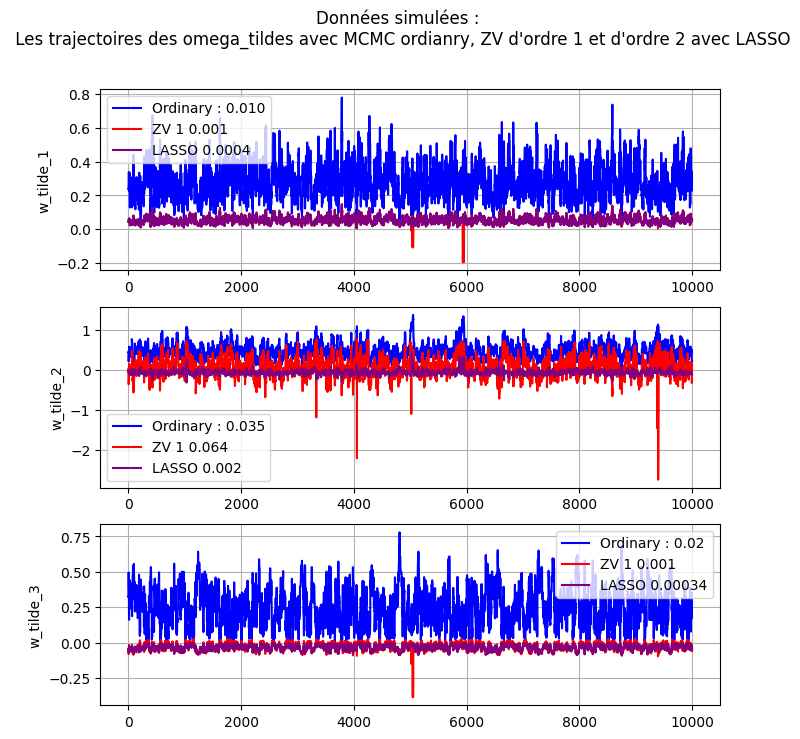

In [90]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(10001), echant_sim_10[:,0][1000:], label="Ordinary : {:.3f}".format(np.var(echant_sim_10[1000:,0])), color = 'blue')
axs[0].plot(range(10001), omega_tilde_1ss_z1[1000:], label="ZV 1 {:.3f}".format(np.var(omega_tilde_1ss_z1[1000:])), color = 'red')
axs[0].plot(range(10001), omega_tilde_1_sim_LASSO_ss[1000:], label="LASSO {:.4f}".format(np.var(omega_tilde_1_sim_LASSO_ss[1000:])), color = 'purple')

axs[0].set_ylabel('w_tilde_1')
axs[0].grid()
axs[0].legend()

axs[1].plot(range(10001), echant_sim_10[:,1][1000:], label="Ordinary : {:.3f}".format(np.var(echant_sim_10[1000:,1])), color = 'blue')
axs[1].plot(range(10001), omega_tilde_2ss_z1[1000:],  label="ZV 1 {:.3f}".format(np.var(omega_tilde_2ss_z1[1000:])),  color = 'red')
axs[1].plot(range(10001), omega_tilde_2_sim_LASSO_ss[1000:], label="LASSO {:.3f}".format(np.var(omega_tilde_2_sim_LASSO_ss[1000:])), color = 'purple')

axs[1].set_ylabel('w_tilde_2')
axs[1].grid()
axs[1].legend()

axs[2].plot(range(10001), echant_sim_10[:,2][1000:], label="Ordinary : {:.2f}".format(np.var(echant_sim_10[1000:,2])), color = 'blue')
axs[2].plot(range(10001), omega_tilde_3ss_z1[1000:],  label="ZV 1 {:.3f}".format(np.var(omega_tilde_3ss_z1[1000:])), color = 'red')
axs[2].plot(range(10001), omega_tilde_3_sim_LASSO_ss[1000:], label="LASSO {:.5f}".format(np.var(omega_tilde_3_sim_LASSO_ss[1000:])), color = 'purple')

axs[2].set_ylabel('w_tilde_3')
axs[2].grid()
axs[2].legend()

plt.suptitle("Données simulées : \n Les trajectoires des omega_tildes avec MCMC ordianry, ZV d'ordre 1 et d'ordre 2 avec LASSO")
plt.show()

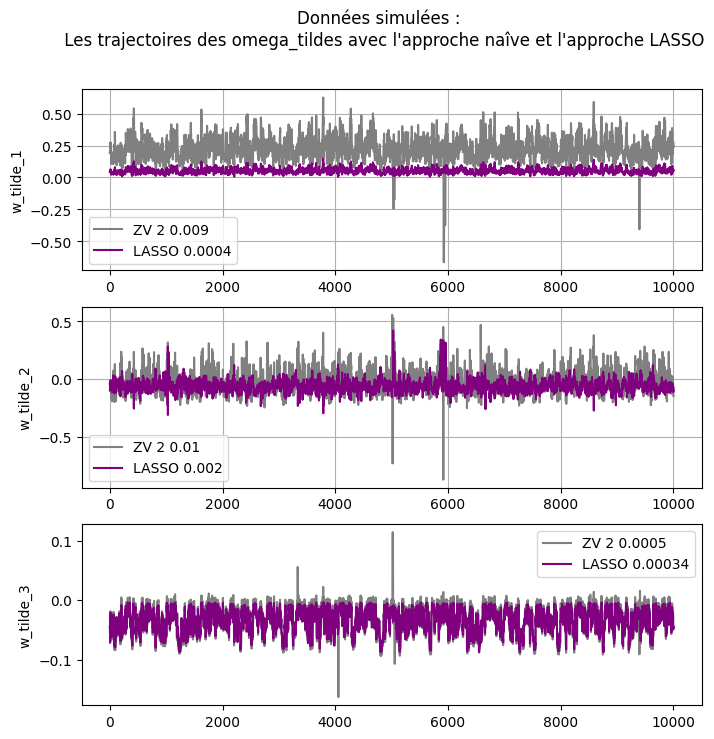

In [91]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(10001), omega_tilde_1ss_d2[1000:], label="ZV 2 {:.3f}".format(np.var(omega_tilde_1ss_d2[1000:])), color = 'grey')
axs[0].plot(range(10001), omega_tilde_1_sim_LASSO_ss[1000:], label="LASSO {:.4f}".format(np.var(omega_tilde_1_sim_LASSO_ss[1000:])), color = 'purple')
axs[0].set_ylabel('w_tilde_1')
axs[0].grid()
axs[0].legend()

axs[1].plot(range(10001), omega_tilde_2ss_d2[1000:], label="ZV 2 {:.2f}".format(np.var(omega_tilde_2ss_d2[1000:])), color = 'grey')
axs[1].plot(range(10001), omega_tilde_2_sim_LASSO_ss[1000:], label="LASSO {:.3f}".format(np.var(omega_tilde_2_sim_LASSO_ss[1000:])), color = 'purple')
axs[1].set_ylabel('w_tilde_2')
axs[1].grid()
axs[1].legend()

axs[2].plot(range(10001), omega_tilde_3ss_d2[1000:], label="ZV 2 {:.4f}".format(np.var(omega_tilde_3ss_d2[1000:])), color = 'grey')
axs[2].plot(range(10001), omega_tilde_3_sim_LASSO_ss[1000:], label="LASSO {:.5f}".format(np.var(omega_tilde_3_sim_LASSO_ss[1000:])), color = 'purple')
axs[2].set_ylabel('w_tilde_3')
axs[2].grid()
axs[2].legend()

plt.suptitle("Données simulées : \n Les trajectoires des omega_tildes avec l'approche naîve et l'approche LASSO")
plt.grid()
plt.show()

In [74]:
lam_reel1 = lambda_etoile (CV2_reel_c, echant_reel_2[:,0])
beta_LASSO_reel1 = beta_LASSO (CV2_reel_c, echant_reel_2[:,0], lam_reel1)
omega_tilde_1_reel_LASSO = echant_reel_10[:,0] - reg_non_penal(CV2_reel_c, echant_reel_2[:,0], CV2_reel_l, beta_LASSO_reel1)
omega_tilde_1_reel_LASSO_ss = enlever_outliers(omega_tilde_1_reel_LASSO)

lam_reel2 = lambda_etoile (CV2_reel_c, echant_reel_2[:,1])
beta_LASSO_reel2 = beta_LASSO (CV2_reel_c, echant_reel_2[:,1], lam_reel2)
omega_tilde_2_reel_LASSO = echant_reel_10[:,1] - reg_non_penal(CV2_reel_c, echant_reel_2[:,1], CV2_reel_l, beta_LASSO_reel2)
omega_tilde_2_reel_LASSO_ss = enlever_outliers(omega_tilde_2_reel_LASSO)



lam_reel3 = lambda_etoile (CV2_reel_c, echant_reel_2[:,2])
beta_LASSO_reel3 = beta_LASSO (CV2_reel_c, echant_reel_2[:,2], lam_reel3)
omega_tilde_3_reel_LASSO = echant_reel_10[:,2] - reg_non_penal(CV2_reel_c, echant_reel_2[:,2], CV2_reel_l, beta_LASSO_reel3)
omega_tilde_3_reel_LASSO_ss = enlever_outliers(omega_tilde_3_reel_LASSO)

/home/onyxia/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.251e-01, tolerance: 1.090e-02
  model = cd_fast.enet_coordinate_descent(


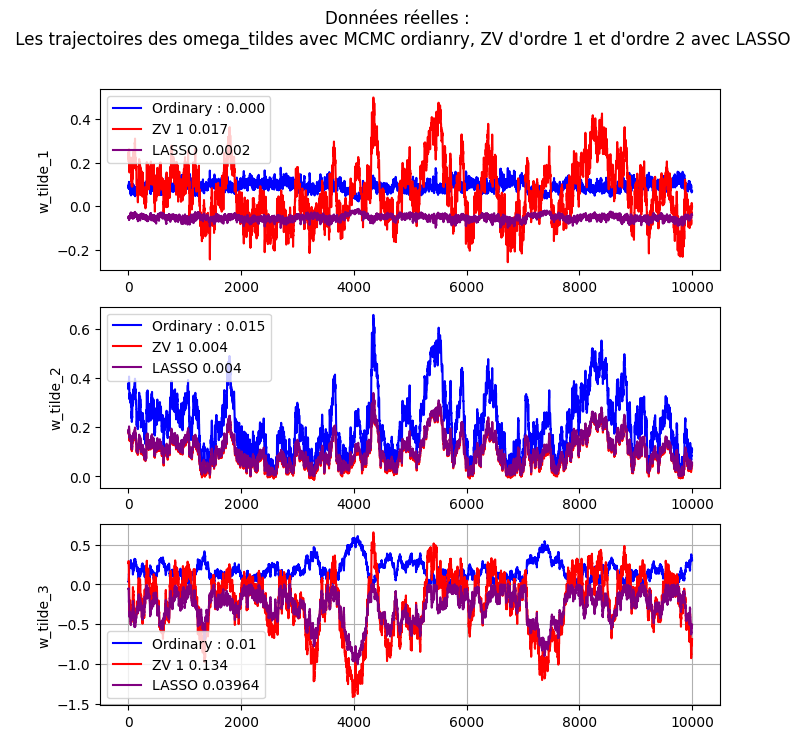

In [77]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(10001), echant_reel_10[:,0][1000:], label="Ordinary : {:.3f}".format(np.var(echant_reel_10[1000:,0])), color = 'blue')
axs[0].plot(range(10001), omega_tilde_1ss_reel[1000:], label="ZV 1 {:.3f}".format(np.var(omega_tilde_1ss_reel[1000:])),  color = 'red')
axs[0].plot(range(10001), omega_tilde_1_reel_LASSO_ss[1000:], label="LASSO {:.4f}".format(np.var(omega_tilde_1_reel_LASSO_ss[1000:])), color = 'purple')

axs[0].set_ylabel('w_tilde_1')
axs[0].legend()

axs[1].plot(range(10001), echant_reel_10[:,1][1000:], label="Ordinary : {:.3f}".format(np.var(echant_reel_10[1000:,1])), color = 'blue')
axs[1].plot(range(10001), omega_tilde_2ss_reel[1000:], label="ZV 1 {:.3f}".format(np.var(omega_tilde_2ss_reel[1000:])),  color = 'red')
axs[1].plot(range(10001), omega_tilde_2_reel_LASSO_ss[1000:], label="LASSO {:.3f}".format(np.var(omega_tilde_2_reel_LASSO_ss[1000:])), color = 'purple')

axs[1].set_ylabel('w_tilde_2')
axs[1].legend()

axs[2].plot(range(10001), echant_reel_10[:,2][1000:], label="Ordinary : {:.2f}".format(np.var(echant_reel_10[1000:,2])), color = 'blue')
axs[2].plot(range(10001), omega_tilde_3ss_reel[1000:], label="ZV 1 {:.3f}".format(np.var(omega_tilde_3ss_reel[1000:])),  color = 'red')
axs[2].plot(range(10001), omega_tilde_3_reel_LASSO_ss[1000:], label="LASSO {:.5f}".format(np.var(omega_tilde_3_reel_LASSO_ss[1000:])), color = 'purple')

axs[2].set_ylabel('w_tilde_3')
axs[2].legend()

plt.suptitle("Données réelles : \n Les trajectoires des omega_tildes avec MCMC ordianry, ZV d'ordre 1 et d'ordre 2 avec LASSO")
plt.grid()
plt.show()

Text(0.5, 0.98, "Données réelles : \n Les trajectoires des omega_tildes avec l'approche naîve et l'approche LASSO")

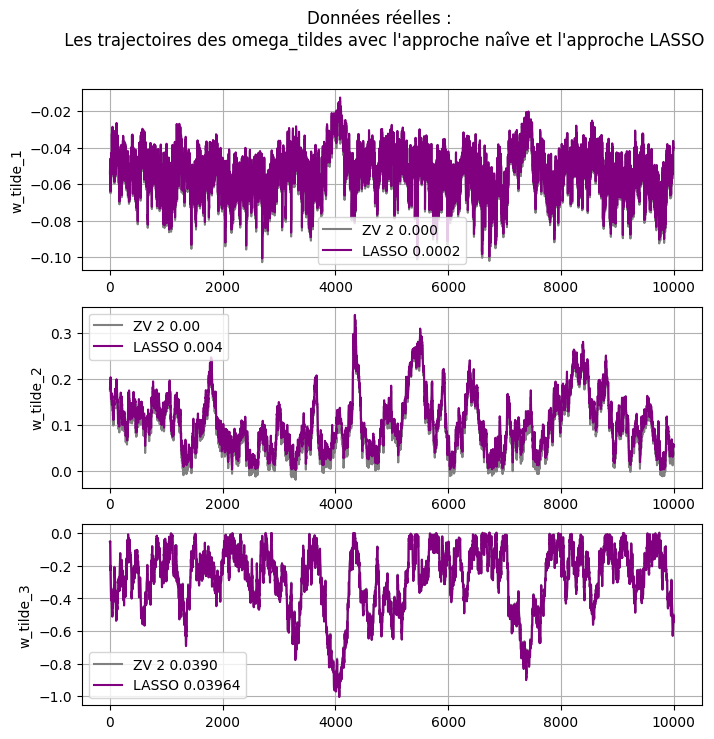

In [82]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

axs[0].plot(range(10001), omega_tilde_1ss_d2_reel[1000:], label="ZV 2 {:.3f}".format(np.var(omega_tilde_1ss_d2_reel[1000:])), color = 'grey')
axs[0].plot(range(10001), omega_tilde_1_reel_LASSO_ss[1000:], label="LASSO {:.4f}".format(np.var(omega_tilde_1_reel_LASSO_ss[1000:])), color = 'purple')
axs[0].set_ylabel('w_tilde_1')
axs[0].grid()
axs[0].legend()

axs[1].plot(range(10001), omega_tilde_2ss_d2_reel[1000:], label="ZV 2 {:.2f}".format(np.var(omega_tilde_2ss_d2_reel[1000:])), color = 'grey')
axs[1].plot(range(10001), omega_tilde_2_reel_LASSO_ss[1000:], label="LASSO {:.3f}".format(np.var(omega_tilde_2_reel_LASSO_ss[1000:])), color = 'purple')
axs[1].set_ylabel('w_tilde_2')
axs[1].grid()
axs[1].legend()

axs[2].plot(range(10001), omega_tilde_3ss_d2_reel[1000:], label="ZV 2 {:.4f}".format(np.var(omega_tilde_3ss_d2_reel[1000:])), color = 'grey')
axs[2].plot(range(10001), omega_tilde_3_reel_LASSO_ss[1000:], label="LASSO {:.5f}".format(np.var(omega_tilde_3_reel_LASSO_ss[1000:])), color = 'purple')
axs[2].set_ylabel('w_tilde_3')
axs[2].grid()
axs[2].legend()

plt.suptitle("Données réelles : \n Les trajectoires des omega_tildes avec l'approche naîve et l'approche LASSO")

In [92]:
def metropolis2 (returns, omega_current, n_iter, var, sigma):
    j = 0 
    omega_matrix = omega_current 
    # np.random.seed(12)
    for i in range (0,n_iter):
        omega_n = omega_current + np.random.normal(loc=0, scale=sigma, size=3)
        while np.any(omega_n <=0 ) :
            omega_n = omega_current + np.random.normal(loc=0, scale=sigma, size=3)
        r = posterior (returns, omega_n, var)/posterior (returns, omega_current, var)
        if np.random.uniform() < min(1,r) : 
            omega_current = omega_n 
            j = j + 1
        omega_matrix = np.vstack((omega_matrix, omega_current)) 
    return j/n_iter, omega_matrix
omega_current = np.array([0.05,0.244,0.598])
var = [100,100,100]
Sigma_opt_sim = 0.1
echant_sim_2 = metropolis2 (y, omega_current, 3000, var, Sigma_opt_sim)[1]
echant_sim_10 = metropolis2 (y, omega_current, 11000, var, Sigma_opt_sim)[1]
Sigma_opt_reel = 0.019195959595959596
echant_reel_2 = metropolis2 (r, omega_current, 3000, var, Sigma_opt_reel)[1]
echant_reel_10 = metropolis2 (r, omega_current, 11000, var, Sigma_opt_reel)[1]

In [ ]:
w1_ordinary = []
w1_ZV1 = []
w1_ZV2 = []
w1_LASSO = []

w2_ordinary = []
w2_ZV1 = []
w2_ZV2 = []
w2_LASSO = []

w3_ordinary = []
w3_ZV1 = []
w3_ZV2 = []
w3_LASSO = []

for i in range(100):
    echant_sim_2 = metropolis2 (y, np.array([0.05,0.244,0.598]), 2000, [100,100,100], 0.1)[1]
    echant_sim_10 = metropolis2 (y, np.array([0.05,0.244,0.598]), 10000, [100,100,100], 0.1)[1]
    w1_ordinary.append(echant_sim_10[:,0].mean())
    w2_ordinary.append(echant_sim_10[:,1].mean())
    w3_ordinary.append(echant_sim_10[:,2].mean())
    CV1_sim_1_c = calcul_z_1(echant_sim_2, h[:100], y[:100], np.var(echant_sim_2, axis = 0))
    CV1_sim_1_l = calcul_z_1(echant_sim_10, h[:100], y[:100], np.var(echant_sim_10, axis = 0))
    combi_omega1 = combi_omega(0, echant_sim_2, CV1_sim_1_c, CV1_sim_1_l)
    omega_tilde_1 = echant_sim_10[:,0] - combi_omega1
    omega_tilde_1ss_z1 = enlever_outliers(omega_tilde_1)
    w1_ZV1.append(omega_tilde_1ss_z1.mean())
    combi_omega2 = combi_omega(1, echant_sim_2, CV1_sim_1_c, CV1_sim_1_l)
    omega_tilde_2 = echant_sim_10[:,1] - combi_omega2
    omega_tilde_2ss_z1 = enlever_outliers(omega_tilde_2)
    w2_ZV1.append(omega_tilde_2ss_z1.mean())
    combi_omega3 = combi_omega(2, echant_sim_2, CV1_sim_1_c, CV1_sim_1_l)
    omega_tilde_3 = echant_sim_10[:,2] - combi_omega3
    omega_tilde_3ss_z1 = enlever_outliers(omega_tilde_3)
    w3_ZV1.append(omega_tilde_3ss_z1.mean())
    CV2_sim_c = control_variates_2 (echant_sim_2, CV1_sim_1_c)
    CV2_sim_l = control_variates_2 (echant_sim_10, CV1_sim_1_l)
    combi_omega1_d2 = combi_omega(0, echant_sim_2, CV2_sim_c, CV2_sim_l)
    omega_tilde_1_d2 = echant_sim_10[:,0] - combi_omega1_d2
    omega_tilde_1ss_d2 = enlever_outliers(combi_omega1_d2)
    w1_ZV2.append(omega_tilde_1ss_d2.mean())
    combi_omega2_d2 = combi_omega(1, echant_sim_2, CV2_sim_c, CV2_sim_l)
    omega_tilde_2_d2 = echant_sim_10[:,1] - combi_omega2_d2
    omega_tilde_2ss_d2 = enlever_outliers(omega_tilde_2_d2)
    w2_ZV2.append(omega_tilde_2ss_d2.mean())
    combi_omega3_d2 = combi_omega(2, echant_sim_2, CV2_sim_c, CV2_sim_l)
    omega_tilde_3_d2 = echant_sim_10[:,2] - combi_omega3_d2
    omega_tilde_3ss_d2 = enlever_outliers(omega_tilde_3_d2)
    w3_ZV2.append(omega_tilde_3ss_d2.mean())
    lam_sim1 = lambda_etoile (CV2_sim_c, echant_sim_2[:,0])
    beta_LASSO_sim1 = beta_LASSO (CV2_sim_c, echant_sim_2[:,0], lam_sim1)
    omega_tilde_1_sim_LASSO = echant_sim_10[:,0] - reg_non_penal(CV2_sim_c, echant_sim_2[:,0], CV2_sim_l, beta_LASSO_sim1)
    omega_tilde_1_sim_LASSO_ss = enlever_outliers(omega_tilde_1_sim_LASSO)
    w1_LASSO.append(omega_tilde_1_sim_LASSO_ss.mean())
    lam_sim2 = lambda_etoile (CV2_sim_c, echant_sim_2[:,1])
    beta_LASSO_sim2 = beta_LASSO (CV2_sim_c, echant_sim_2[:,1], lam_sim2)
    omega_tilde_2_sim_LASSO = echant_sim_10[:,1] - reg_non_penal(CV2_sim_c, echant_sim_2[:,1], CV2_sim_l, beta_LASSO_sim2)
    omega_tilde_2_sim_LASSO_ss = enlever_outliers(omega_tilde_2_sim_LASSO)
    w2_LASSO.append(omega_tilde_2_sim_LASSO_ss.mean())
    lam_sim3 = lambda_etoile (CV2_sim_c, echant_sim_2[:,2])
    beta_LASSO_sim3 = beta_LASSO (CV2_sim_c, echant_sim_2[:,2], lam_sim3)
    omega_tilde_3_sim_LASSO = echant_sim_10[:,2] - reg_non_penal(CV2_sim_c, echant_sim_2[:,2], CV2_sim_l, beta_LASSO_sim3)
    omega_tilde_3_sim_LASSO_ss = enlever_outliers(omega_tilde_3_sim_LASSO)
    w3_LASSO.append(omega_tilde_3_sim_LASSO_ss.mean())

## Variablité des estimateurs et choix du meilleur 

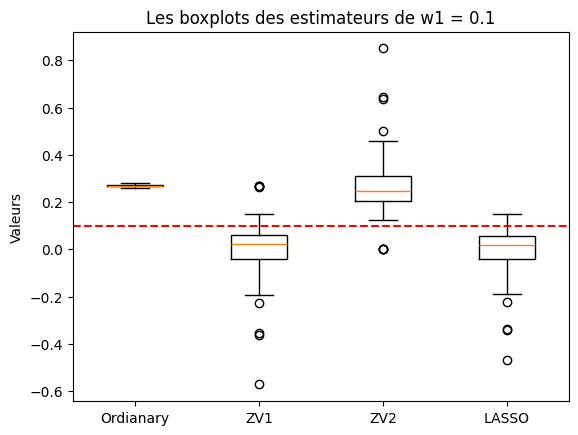

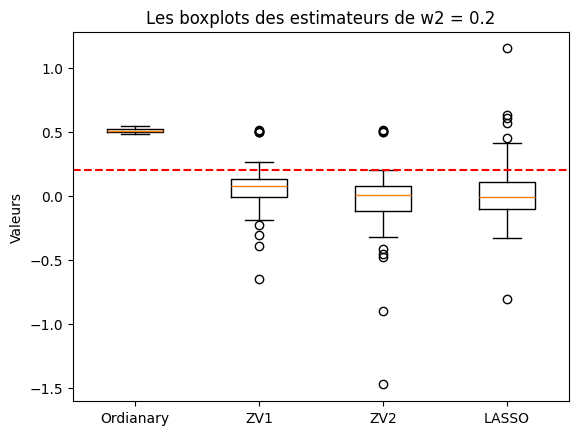

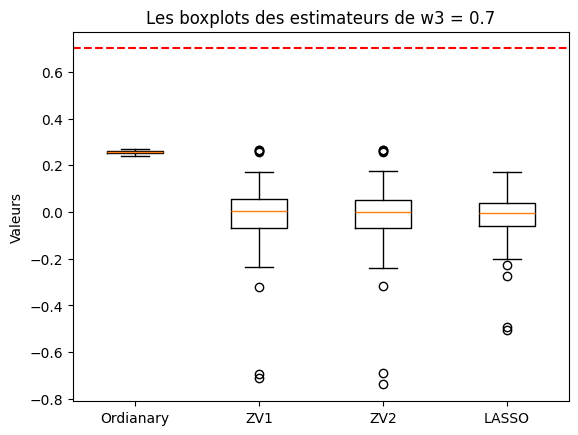

In [95]:

fig, ax = plt.subplots()
ax.boxplot([w1_ordinary, w1_ZV1, w1_ZV2, w1_LASSO])
ax.set_xticklabels(['Ordianary', 'ZV1', 'ZV2', 'LASSO'])
ax.set_title('Les boxplots des estimateurs de w1 = 0.1')
ax.axhline(y=0.1, color='r', linestyle='--')
ax.set_ylabel('Valeurs')
plt.show()


fig, ax = plt.subplots()
ax.boxplot([w2_ordinary, w2_ZV1, w2_ZV2, w2_LASSO])
ax.set_xticklabels(['Ordianary', 'ZV1', 'ZV2', 'LASSO'])
ax.set_title('Les boxplots des estimateurs de w2 = 0.2')
ax.axhline(y=0.2, color='r', linestyle='--')
ax.set_ylabel('Valeurs')
plt.show()


fig, ax = plt.subplots()
ax.boxplot([w3_ordinary, w3_ZV1, w3_ZV2, w3_LASSO])
ax.set_xticklabels(['Ordianary', 'ZV1', 'ZV2', 'LASSO'])
ax.set_title('Les boxplots des estimateurs de w3 = 0.7')
ax.axhline(y=0.7, color='r', linestyle='--')
ax.set_ylabel('Valeurs')
plt.show()